# Module 04: EDA of the Penguins public dataset in BigQuery
For the rest of lab, we will focus on the Penguin dataset in BigQuery (eda, train, tune, batch predictions, online serve).

This notebook is an end to end sample for exploratory data analysis. Its optional and can be skipped.

In [1]:
# Variables
project_id_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = project_id_output[0]
print("Project ID: ", PROJECT_ID)

project_nbr_output = !gcloud projects describe $PROJECT_ID --format='value(projectNumber)'
PROJECT_NBR = project_nbr_output[0]
print("Project Number: ", PROJECT_NBR)

REGION="us-central1"
print("GCP region: ", REGION)

Project ID:  ray-of-sunshine
Project Number:  567162267085
GCP region:  us-central1


In [2]:
import numpy as np #linear algebra
import pandas as pd #data processing
import pandas_gbq #write to BQ

import matplotlib.pyplot as plt #simple data visualization
import seaborn as sns #some advanced data visualizations
import warnings

%matplotlib inline
plt.style.use('seaborn-white') #defining desired style of viz
warnings.filterwarnings('ignore') # to get rid of warnings

from sklearn.preprocessing import LabelEncoder #label encoding
from google.cloud import bigquery


<ipython-input-2-602491edd058>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white') #defining desired style of viz


## [1] Review the source data in BigQuery

In [3]:
%%bigquery

SELECT REGEXP_EXTRACT(species, r'\w+') species, island, culmen_length_mm, culmen_depth_mm, flipper_length_mm, body_mass_g, sex
FROM `bigquery-public-data.ml_datasets.penguins`

    LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie,Dream,39.8,19.1,184.0,4650.0,MALE


## [2] Profile the data

In [4]:
from google.cloud import bigquery

client = bigquery.Client()
sql = """
    SELECT REGEXP_EXTRACT(species, r'\w+') species, island, culmen_length_mm, culmen_depth_mm, flipper_length_mm, body_mass_g, sex FROM `bigquery-public-data.ml_datasets.penguins`
"""

pdf = client.query(sql).to_dataframe()

In [5]:
print('Dataset has', pdf.shape[0] , 'rows and', pdf.shape[1], 'columns')

Dataset has 344 rows and 7 columns


In [6]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [7]:
pdf.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [8]:
pdf.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

## [3] Univariate Analysis of categorical variables



Univariate analysis observes each characteristic or attribute in isolation. It looks at the range of values, as well as the central tendency of the values.



#### 3.1. Species

In [9]:
plt.rcParams['figure.figsize'] = (10,7)

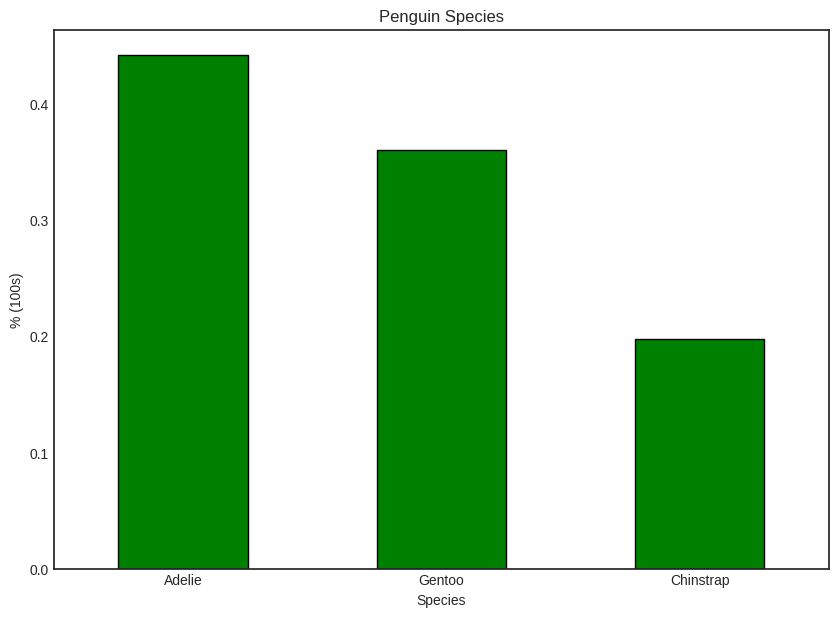

In [10]:
pdf['species'].value_counts(normalize = True).plot(kind = 'bar', color = 'green', linewidth = 1, edgecolor = 'k')
plt.title('Penguin Species')
plt.xlabel('Species')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

#### 3.2. Islands

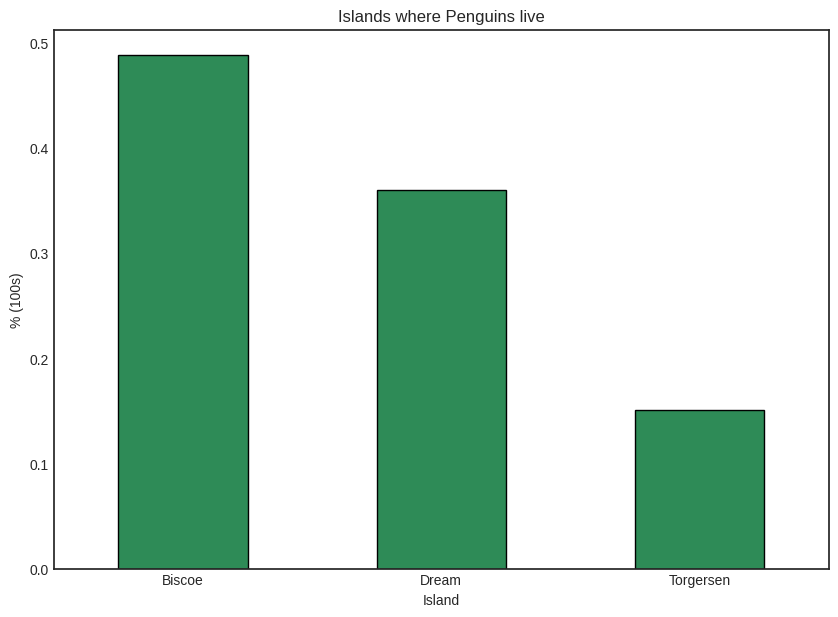

In [11]:
pdf['island'].value_counts(normalize = True).plot(kind = 'bar', color = 'seagreen', linewidth = 1, edgecolor = 'k')
plt.title('Islands where Penguins live')
plt.xlabel('Island')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

#### 3.3. Sex

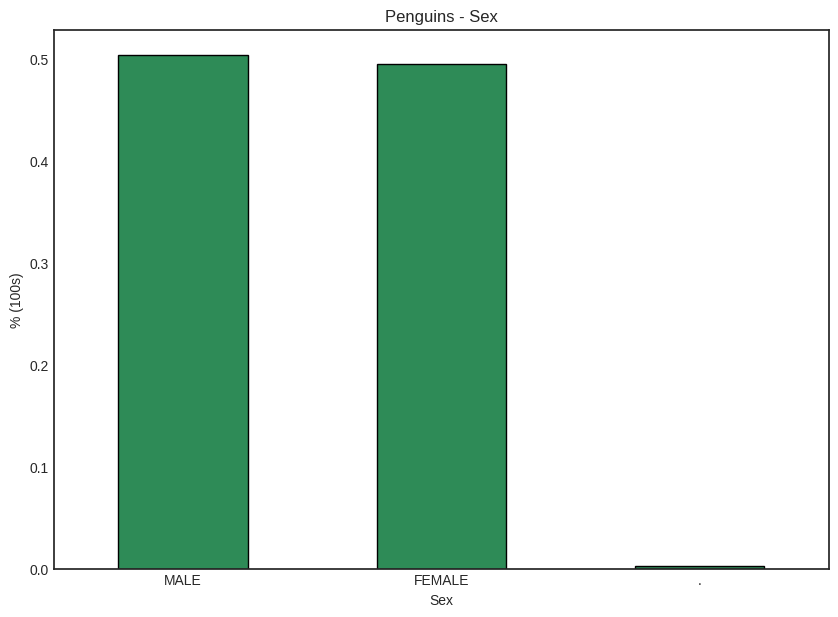

In [12]:
pdf['sex'].value_counts(normalize = True).plot(kind = 'bar', color = 'seagreen', linewidth = 1, edgecolor = 'k')
plt.title('Penguins - Sex')
plt.xlabel('Sex')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

## [4] Univariate analysis of numerical variables


Probability Density Function gives the probability of a random variable x picked at a time. Empirical Cumulative Distribution Function, gives the probability of getting a value less than or equal to a random value picked at a time.


In [13]:
def display_ecd(x):
    n = len(x)
    a = np.sort(x)
    b = np.arange(1, 1 + n) / n
    plt.subplot(211)
    plt.plot(a, b, marker = '.', linestyle = 'None', c = 'seagreen')
    mean_x = np.mean(x)
    plt.axvline(mean_x, c = 'k', label = 'Mean')
    plt.title('ECDF')
    plt.legend()
    plt.show()
    plt.subplot(212)
    sns.distplot(x, color = 'r')
    plt.title('Probability Density Function')
    plt.show()

### 4.1. Culmen length

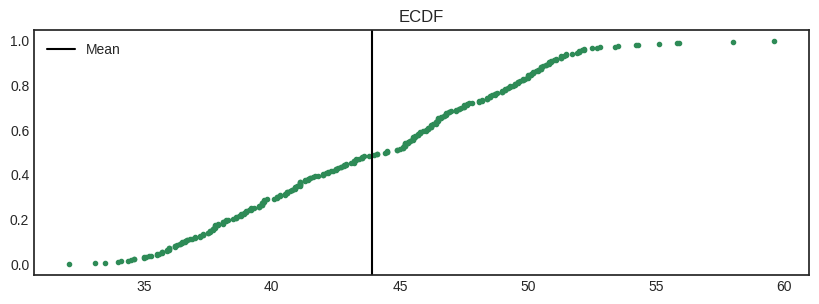

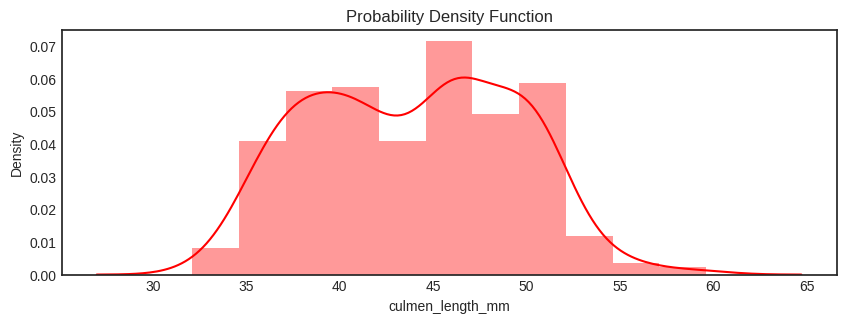

In [14]:
display_ecd(pdf['culmen_length_mm'])

### 4.2. Culmen depth

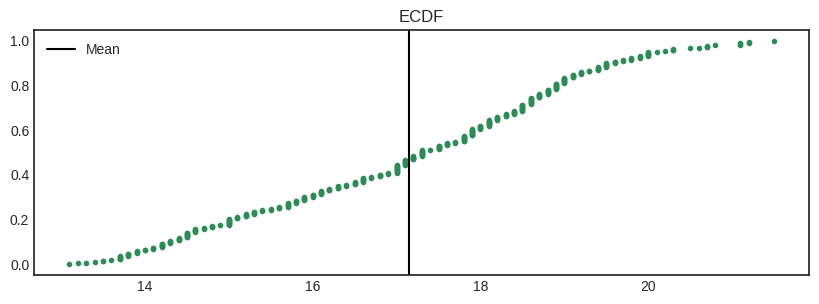

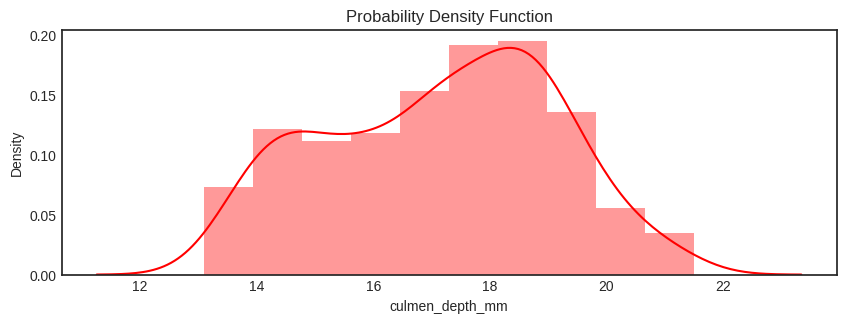

In [15]:
display_ecd(pdf['culmen_depth_mm'])

### 4.3. Flipper length

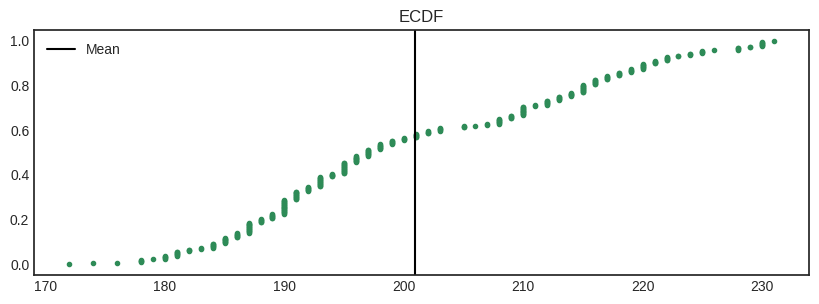

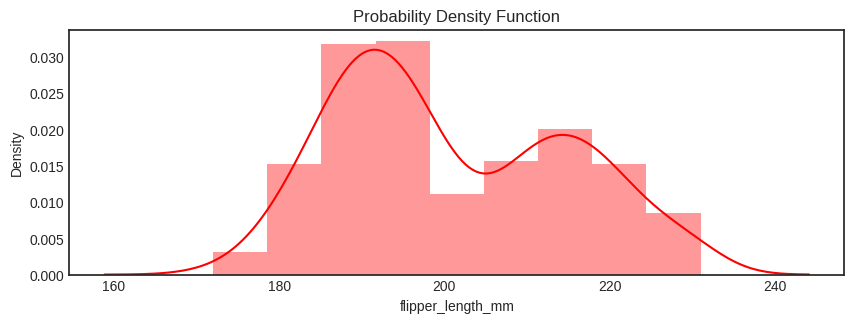

In [16]:
display_ecd(pdf['flipper_length_mm'])

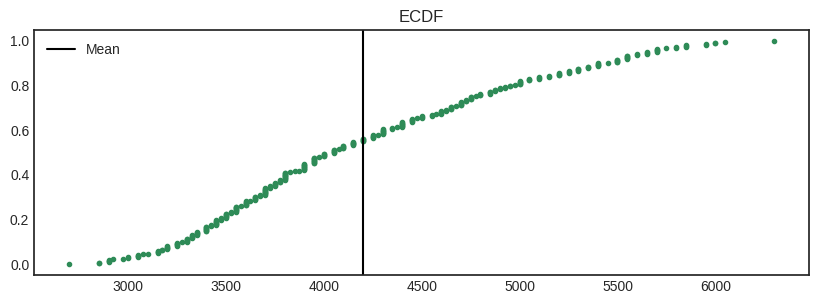

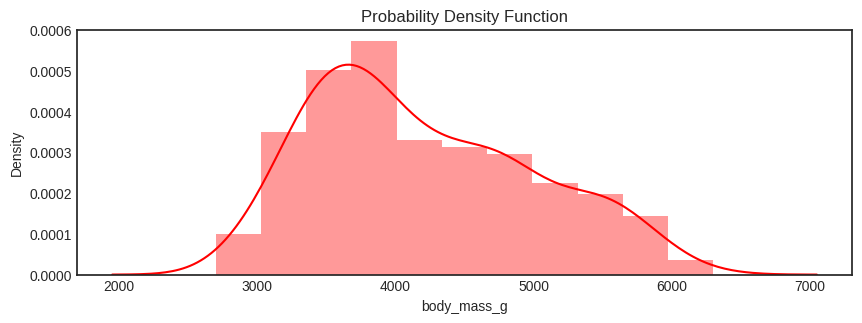

In [17]:
display_ecd(pdf['body_mass_g'])

## [5] Multivariate analysis

In [18]:
def display_boxplot(f):
    sns.boxplot(y = f, x = 'species', hue = 'sex',data = pdf)
    plt.title(f)
    plt.show()

### 5.1. Culmen length with species and gender

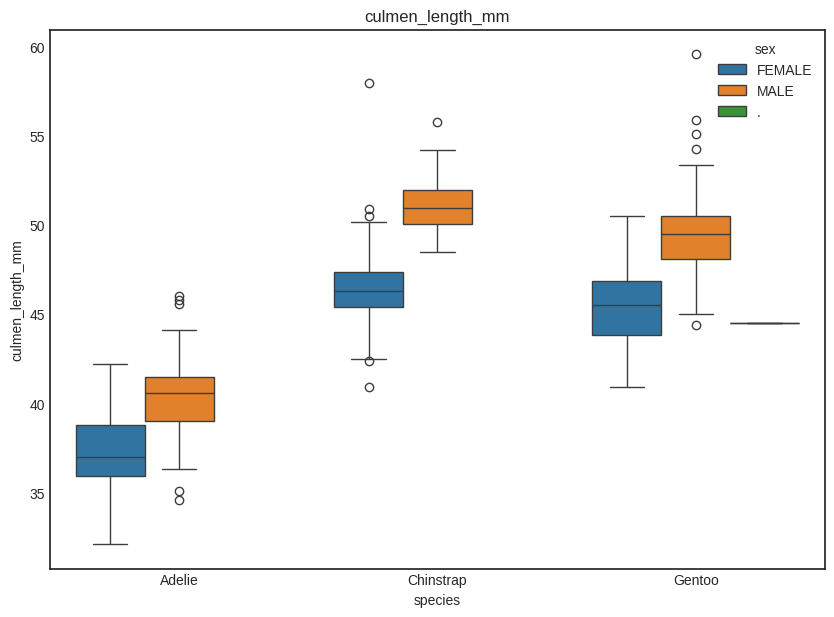

In [19]:
display_boxplot('culmen_length_mm')

### 5.2. Culmen depth with species and gender

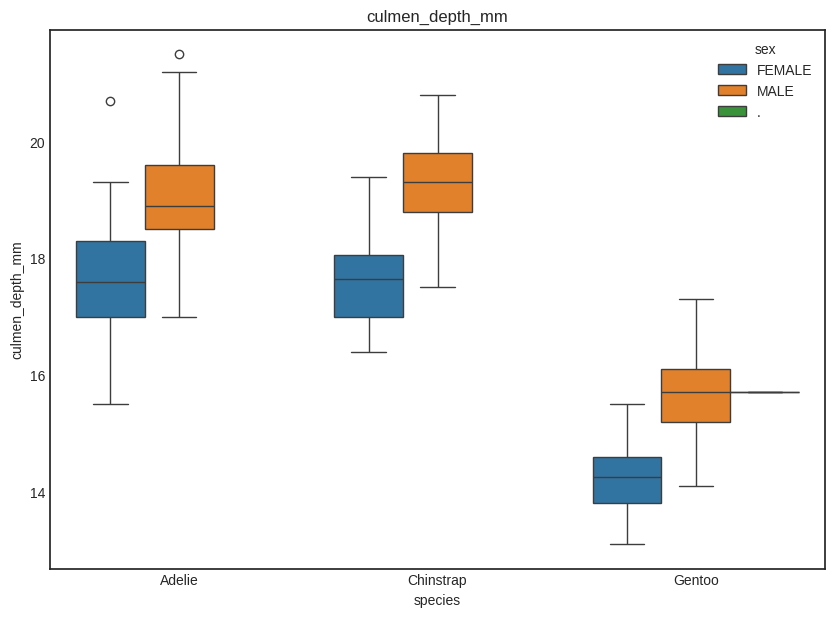

In [20]:
display_boxplot('culmen_depth_mm')


### 5.3. Flipper length with species and gender

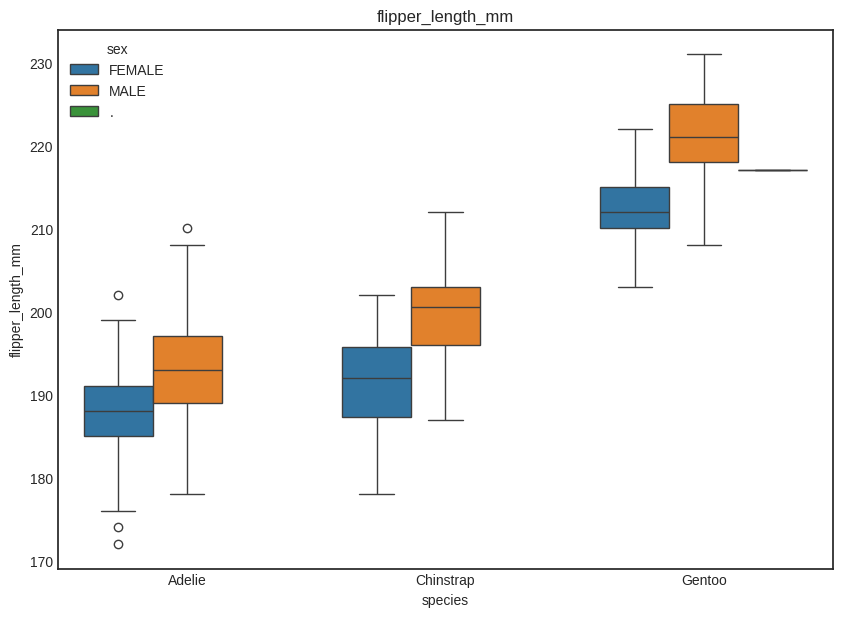

In [21]:
display_boxplot('flipper_length_mm')

### 5.4. Body mass with species and gender

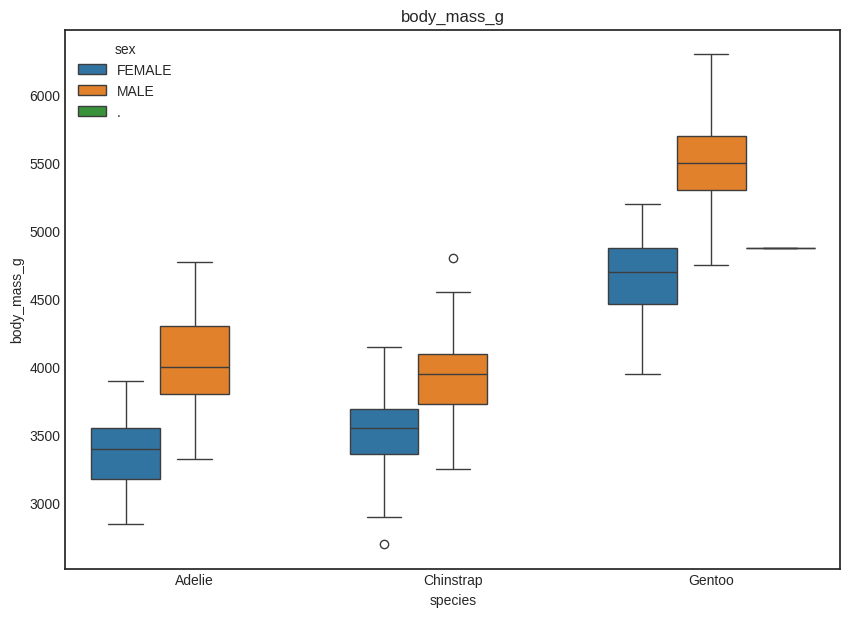

In [22]:
display_boxplot('body_mass_g')

### **OBSERVATION:**

The male penguins have higher values of body mass, culmen & flipper lengths, culmen depth

### 5.5. **Pairplot** to visualize multivariate trends across attributes

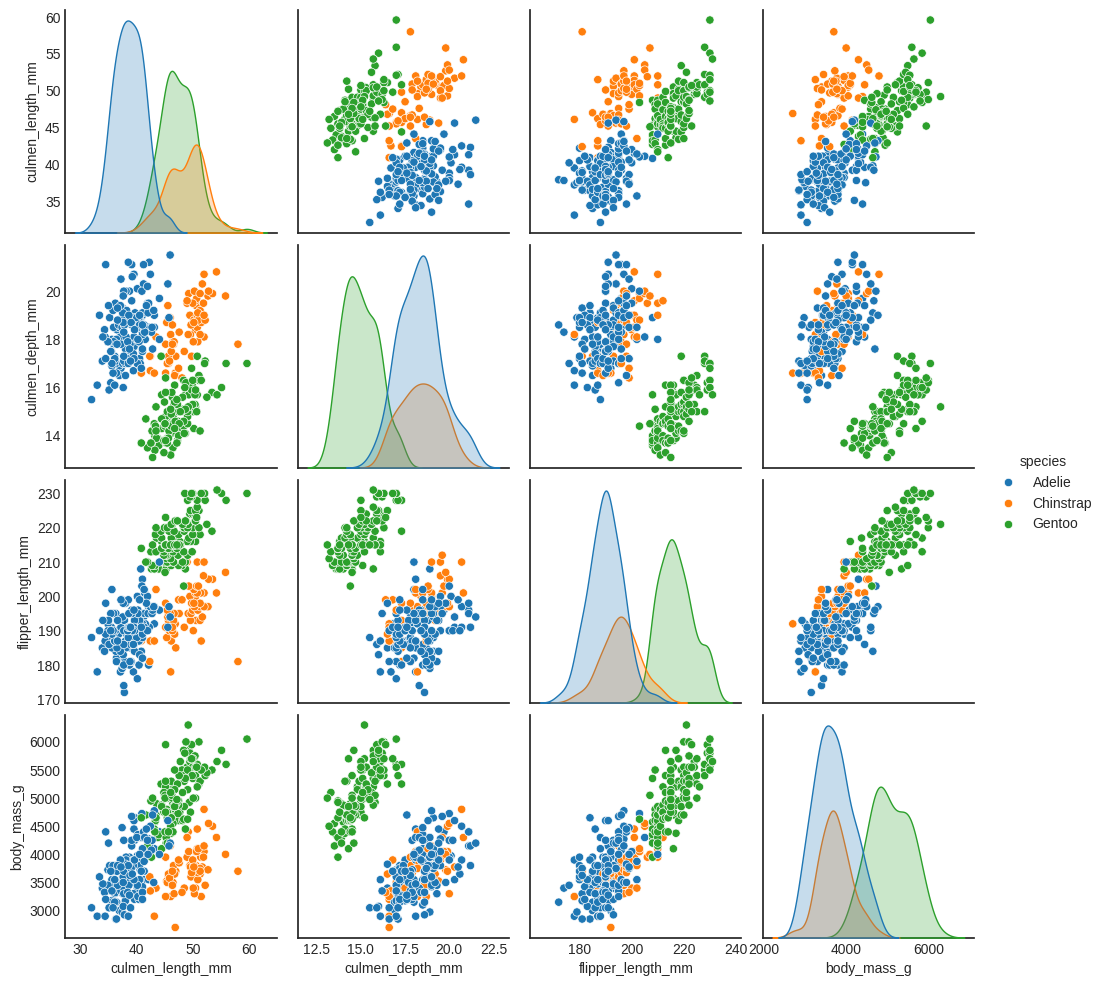

In [23]:
sns.pairplot(pdf, hue = 'species')
plt.show()

This concludes exploratory data analysis.

## [6] Feature Engineering

### 6.1. Missing values

In [24]:
# Check if any of the columns have missing values
pdf.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [25]:
# Lets make a copy of the base dataset and apply in-place missing values imputation
missing_values_imputed_df = pdf.copy()

In [26]:
# Imputation strategy: Apply mean for the numerical columns
missing_values_imputed_df['culmen_length_mm'].fillna(np.mean(pdf['culmen_length_mm']), inplace = True)
missing_values_imputed_df['culmen_depth_mm'].fillna(np.mean(pdf['culmen_depth_mm']), inplace = True)
missing_values_imputed_df['flipper_length_mm'].fillna(np.mean(pdf['flipper_length_mm']), inplace = True)
missing_values_imputed_df['body_mass_g'].fillna(np.mean(pdf['body_mass_g']), inplace = True)

# Imputation strategy: Apply mode for the categorical columns
missing_values_imputed_df['sex'].fillna(pdf['sex'].mode()[0], inplace = True)

In [27]:
missing_values_imputed_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie,Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie,Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap,Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie,Dream,37.3,16.8,192.0,3000.0,FEMALE


In [28]:
missing_values_imputed_df.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### 6.2. Skew

In [29]:
print('Skewness in numeric variables')
print('-' * 60)

for i in missing_values_imputed_df.select_dtypes(['int64', 'float64']).columns.tolist():
    print(i, ' : ',missing_values_imputed_df[i].skew())

Skewness in numeric variables
------------------------------------------------------------
culmen_length_mm  :  0.05327178883163406
culmen_depth_mm  :  -0.1438798068350748
flipper_length_mm  :  0.34668222408256016
body_mass_g  :  0.4716904472211899


Skewness score:

Skewness values within the range of -1 and -0.5 (negative skewed) or 0.5 and 1(positive skewed) indicate slightly skewed data distributions. Data with skewness values less than -1 (negative skewed) or greater than 1 (positive skewed) are considered highly skewed.


Interpreting the results:
Skew is not a great concern

### 6.3. Normalization

Data normalization is a technique used to transform the values of a dataset into a common scale. This is important because many machine learning algorithms are sensitive to the scale of the input features and can produce better results when the data is normalized.

#### 6.3.1. Numerical values - scaling

In [30]:
# Lets use sklearn's MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [31]:
missing_values_imputed_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie,Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie,Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap,Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie,Dream,37.3,16.8,192.0,3000.0,FEMALE


In [32]:
missing_values_imputed_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,344.000000,344.000000,344.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.443643,1.969027,14.020657,799.613058
min,32.100000,13.100000,172.000000,2700.000000
25%,39.275000,15.600000,190.000000,3550.000000
50%,44.250000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [33]:
imputed_scaled_df = missing_values_imputed_df.copy()

In [34]:
imputed_scaled_df['culmen_length_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['culmen_length_mm'].values.reshape(-1, 1))
imputed_scaled_df['culmen_depth_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['culmen_depth_mm'].values.reshape(-1, 1))
imputed_scaled_df['flipper_length_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['flipper_length_mm'].values.reshape(-1, 1))
imputed_scaled_df['body_mass_g'] = min_max_scaler.fit_transform(missing_values_imputed_df['body_mass_g'].values.reshape(-1, 1))

In [35]:
imputed_scaled_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Dream,0.163636,0.630952,0.203390,0.215278,FEMALE
1,Adelie,Dream,0.280000,0.714286,0.203390,0.541667,MALE
2,Adelie,Dream,0.320000,0.690476,0.203390,0.333333,MALE
3,Chinstrap,Dream,0.523636,0.571429,0.338983,0.222222,FEMALE
4,Adelie,Dream,0.189091,0.440476,0.338983,0.083333,FEMALE


In [36]:
imputed_scaled_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,344.000000,344.000000,344.000000,344.000000
mean,0.429888,0.482282,0.490088,0.417154
std,0.197951,0.234408,0.237638,0.222115
min,0.000000,0.000000,0.000000,0.000000
25%,0.260909,0.297619,0.305085,0.236111
50%,0.441818,0.500000,0.423729,0.375000
75%,0.596364,0.666667,0.694915,0.569444
max,1.000000,1.000000,1.000000,1.000000


#### 6.3.2. Categorical variables - one hot encoding Penguin gender

In [37]:
imputed_scaled_gender_encoded_df=pd.get_dummies(imputed_scaled_df,columns = ['sex'], drop_first=True).drop(['sex_FEMALE'], axis=1)
imputed_scaled_gender_encoded_df.rename(columns={"sex_MALE":"male"}, inplace=True)
imputed_scaled_gender_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,Adelie,Dream,0.163636,0.630952,0.20339,0.215278,0
1,Adelie,Dream,0.280000,0.714286,0.20339,0.541667,1
2,Adelie,Dream,0.320000,0.690476,0.20339,0.333333,1


### 6.3.3. Categorical variables - one hot encoding island

In [38]:
imputed_scaled_encoded_df=imputed_scaled_gender_encoded_df.copy()
imputed_scaled_encoded_df['island'].unique()

array(['Dream', 'Biscoe', 'Torgersen'], dtype=object)

In [39]:
imputed_scaled_encoded_df['island'].replace({'Dream' : 0,
                                'Biscoe' : 1,
                                'Torgersen': 2}, inplace = True)
imputed_scaled_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,Adelie,0,0.163636,0.630952,0.20339,0.215278,0
1,Adelie,0,0.280000,0.714286,0.20339,0.541667,1
2,Adelie,0,0.320000,0.690476,0.20339,0.333333,1


### 6.3.4. Label encoding

In [40]:
le = LabelEncoder()
imputed_scaled_encoded_df['species']= le.fit_transform(imputed_scaled_encoded_df['species'])
imputed_scaled_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,0,0,0.163636,0.630952,0.20339,0.215278,0
1,0,0,0.280000,0.714286,0.20339,0.541667,1
2,0,0,0.320000,0.690476,0.20339,0.333333,1


In [41]:
imputed_scaled_encoded_df.describe()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.918605,0.790698,0.429888,0.482282,0.490088,0.417154,0.517442
std,0.893320,0.684970,0.197951,0.234408,0.237638,0.222115,0.500424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.260909,0.297619,0.305085,0.236111,0.000000
50%,1.000000,1.000000,0.441818,0.500000,0.423729,0.375000,1.000000
75%,2.000000,1.000000,0.596364,0.666667,0.694915,0.569444,1.000000
max,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
imputed_scaled_encoded_df.species.unique()

array([0, 1, 2])

In [43]:
imputed_scaled_encoded_df.island.unique()

array([0, 1, 2])

In [44]:
imputed_scaled_encoded_df.male.unique()

array([0, 1], dtype=uint8)

### 6.3.5. Correlation

<Axes: >

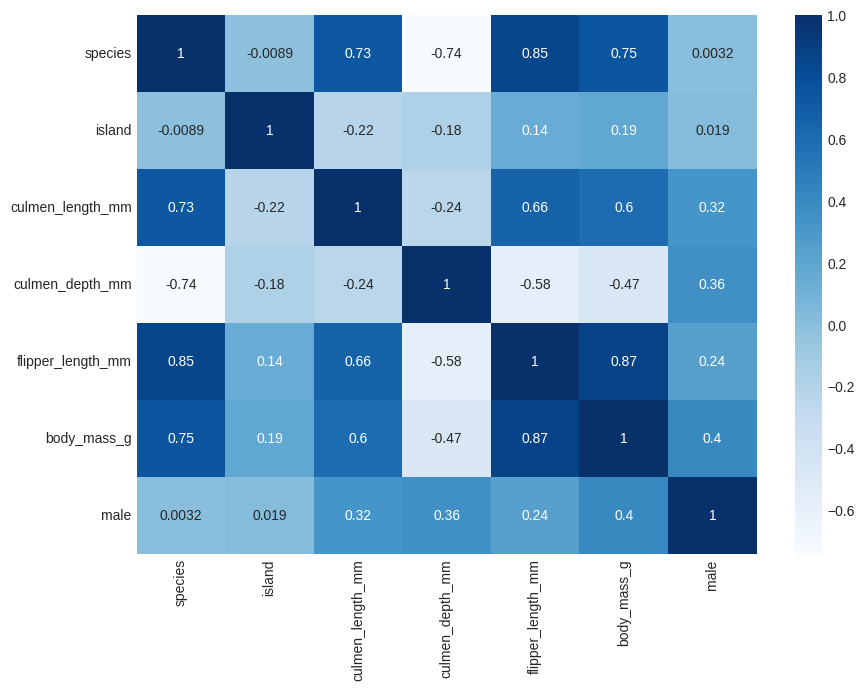

In [45]:
sns.heatmap(imputed_scaled_encoded_df.corr(), annot = True, cmap = 'Blues')